# Some Visualizations: #

For better visualizations we have picked ten videos which are part of a playlist about Python Sentiment Analysis.

## Let's get the Data from the Database and visualize it: ##

Due to the fact, that we use the graph database Neo4j, we have to initialize its connection with the bolt protocol.

In [5]:
from neo4j import GraphDatabase

uri, user, password = 'bolt://localhost:11005', 'neo4j', 'neo4j_'
driver = GraphDatabase.driver(uri, auth=(user, password))

Foremostly we implement a statement to get all scraped video metadata and save them in an array.

In [6]:
# get video metadata

videos_with_metadata = []

with driver.session() as session:
    def _q(query) : return session.run(query)
    #---------------------------------------

    result = _q("MATCH (v:Video) WHERE v.title STARTS WITH 'Sentiment Analysis Python - ' RETURN v.title, v.date, v.likes, v.dislikes ORDER BY v.date")
 
    for record in result:
        
        videos_with_metadata.append({
            "title": record['v.title'],
            "date": record['v.date'],
            "likes": record['v.likes'],
            "dislikes": record['v.dislikes'],
        })    
    #---------------------------------------
driver.close() 

### Pandas Dataframe: ###

Now we create a pandas data frame to access convient functions for data manipulation.

We also have to convert the amount of likes and dislikes of each video to integer, as well as the date to its corresponding data type.

In [7]:
import pandas as pd

video_df = pd.DataFrame(videos_with_metadata)

video_df['title'] = video_df['title'].astype(str)
video_df['date'] = video_df['date'].astype(str)

video_df['likes'] = video_df['likes'].astype(int)
video_df['dislikes'] = video_df['dislikes'].astype(int)

print(video_df.dtypes)

video_df

title       object
date        object
likes        int32
dislikes     int32
dtype: object


,title,date,likes,dislikes
0,Sentiment Analysis Python - 6 - Counting Emoti...,04.03.2020,71,2
1,Sentiment Analysis Python - 1 - Introduction ...,04.03.2020,182,4
2,Sentiment Analysis Python - 4 - Tokenization a...,04.03.2020,113,1
3,Sentiment Analysis Python - 7 - Emotions in a...,04.03.2020,75,0
4,Sentiment Analysis Python - 2 - Creating Proj...,04.03.2020,49,3
5,Sentiment Analysis Python - 3 - Cleaning Text...,04.03.2020,119,2
6,Sentiment Analysis Python - 5 - Algorithm for ...,04.03.2020,126,3
7,Sentiment Analysis Python - 10 - Positive or ...,14.03.2020,185,3
8,Sentiment Analysis Python - 9 - Installing NL...,14.03.2020,77,0
9,Sentiment Analysis Python - 8 - Twitter Emoti...,14.03.2020,169,0


### Using matplotlib for visualizing the Data: ###

After piping the data into the data frame, we will vizualize the likes and dislikes in a horizontal bar chart.

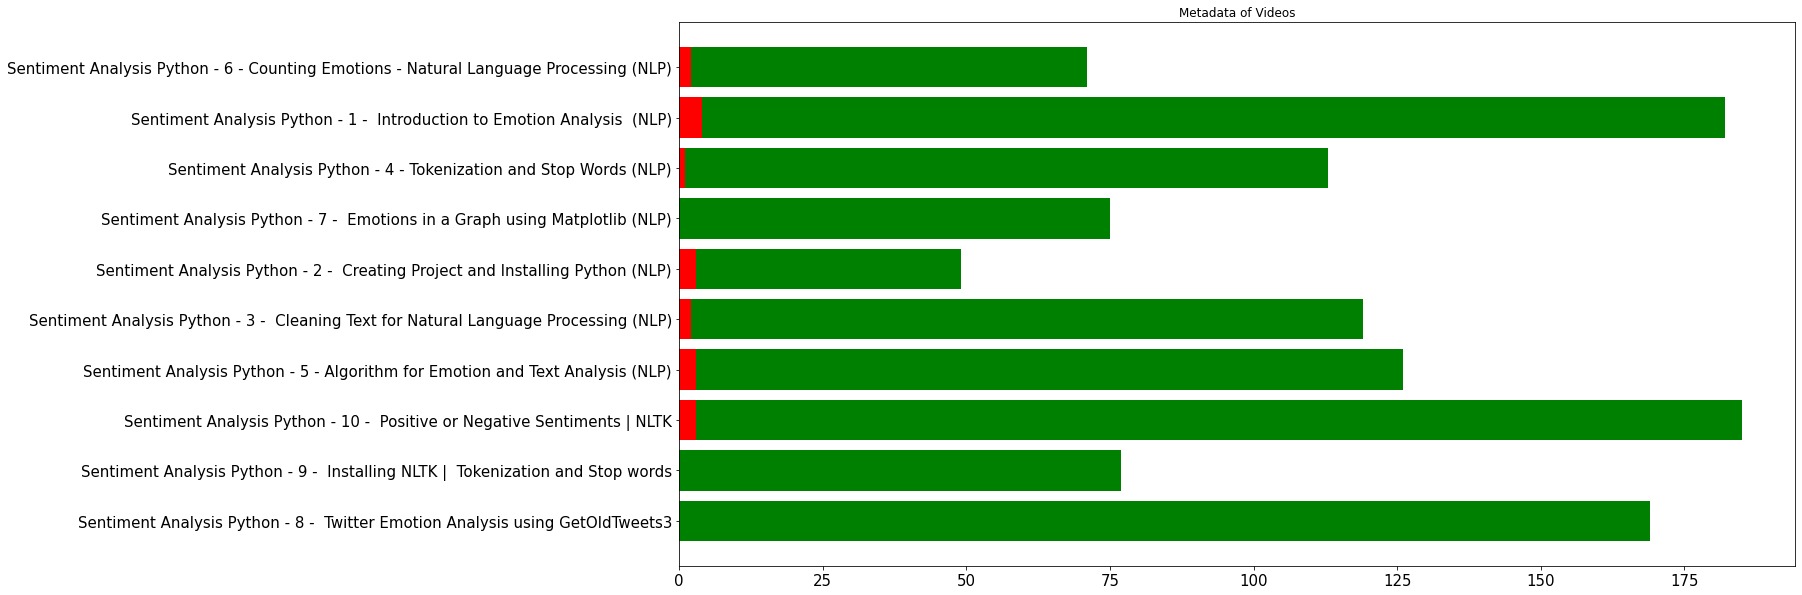

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))

ax.barh(video_df['title'], video_df['likes'], color='green', label='likes')
ax.barh(video_df['title'], video_df['dislikes'], color='red', label='dislikes')

ax.set_title("Metadata of Videos")
ax.invert_yaxis();
ax.tick_params(labelsize=15)

plt.show()

Wow, it seems that the watchers of the videos really like what they see. The likes are illustrated as green bars and the dislikes are the red ones.


To gain a better understanding of how these two features correlate, we will calculate a ratio between these two and plot it for each video and add them to the data frame.

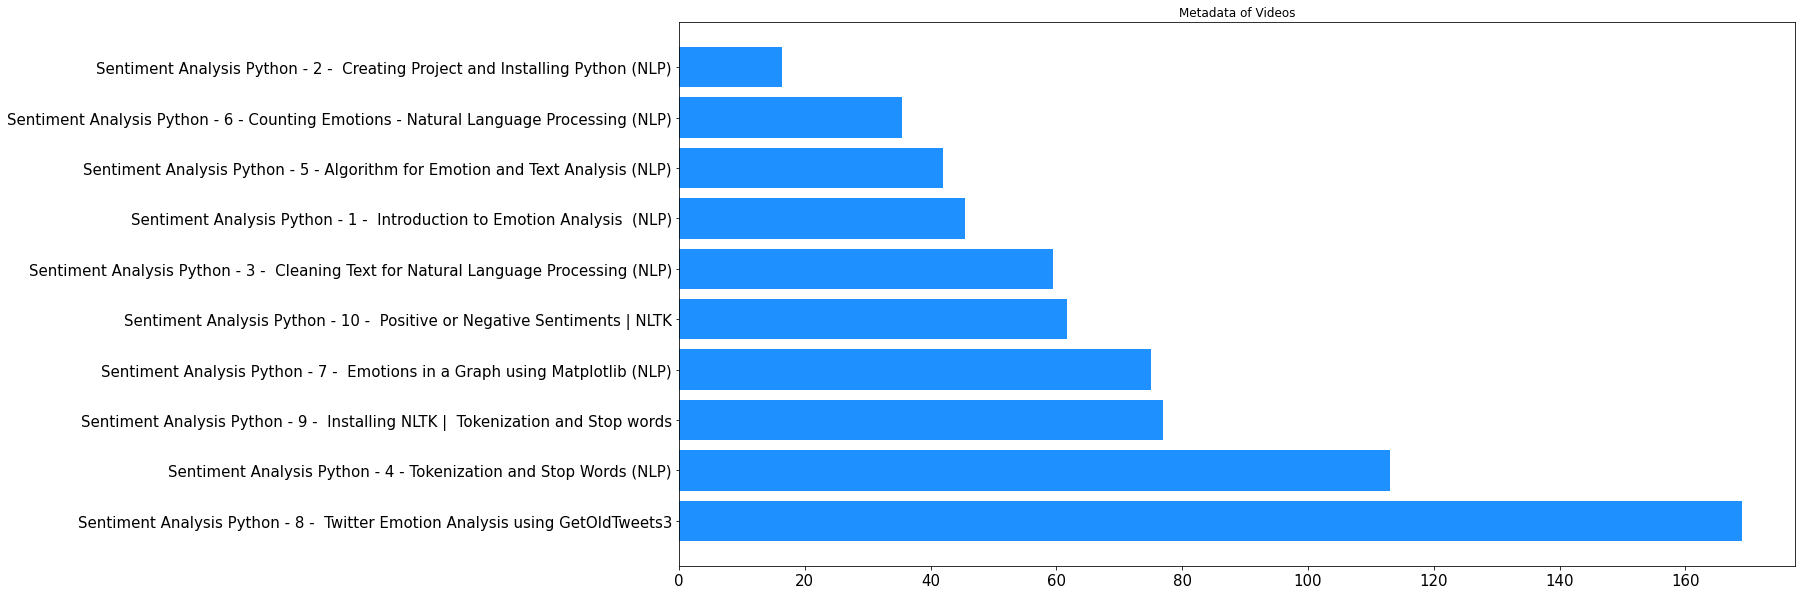

In [9]:
fig, ax = plt.subplots(figsize=(20,10))

video_df['like_dislike_ratio'] = video_df['likes'] / (video_df['dislikes'].replace(0, 1)) # replace 0 with 1 to avoid division by zero

sorted_video_df = video_df.sort_values(by=['like_dislike_ratio'])

ax.barh(sorted_video_df['title'], sorted_video_df['like_dislike_ratio'], color='dodgerblue', label='likes')

ax.set_title("Metadata of Videos")
ax.invert_yaxis();
ax.tick_params(labelsize=15)

plt.show()

Before printing boxplots of each likes and dislikes, let's print some statistical data of these two features.

In [10]:
video_df.describe()

,likes,dislikes,like_dislike_ratio
count,10.000000,10.00000,10.000000
mean,116.600000,1.80000,69.450000
std,49.166836,1.47573,43.913147
min,49.000000,0.00000,16.333333
25%,75.500000,0.25000,42.875000
50%,116.000000,2.00000,60.583333
75%,158.250000,3.00000,76.500000
max,185.000000,4.00000,169.000000


Now that we got some statistical data about it, we can plot them in a boxplot.

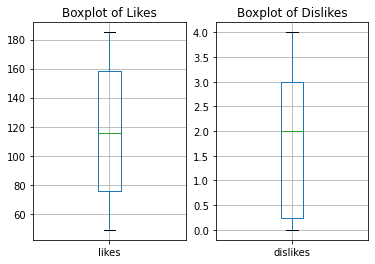

In [11]:
plt.tight_layout()

# add boxplot of likes
plt.subplot(1, 2, 1)
plt.title("Boxplot of Likes")
video_df.boxplot(column='likes')

# show boxplot of dislikes
plt.subplot(1, 2, 2)
plt.title("Boxplot of Dislikes")
video_df.boxplot(column='dislikes')
plt.show()

## Let's get some comments data from our graph database: ##

Enough played with video metadata, let's analyze the comments of the videos.
To get each comment, we send a query to our Neo4j server which returns the author of each one. We then replace emojis and punctuation characters with an empty character. 

In [12]:
# get comment data

import string

words = []
comments = []
scores = []

with driver.session() as session:
    def _q(query) : return session.run(query)
    #---------------------------------------

    result = _q("MATCH (a:Author)-[c:COMMENTED]->(v:Video) WHERE v.title STARTS WITH 'Sentiment Analysis Python - ' RETURN c")
 
    for record in result:        
        comment_text = ((record['c']['text'].lower())
                    .replace('❤️' , '').replace('💯', '').replace('❤' , '')
                    .replace('🙏', '').replace('😘', '').replace('🤗', '')
                    .replace('💥', '').replace('✔️' , '').replace('😍', '')
                    .replace('🐱', '').replace('💔', '').replace('😵', '') 
                    .replace('😄', '').replace('👍', '').replace('😎', '')
                    .replace('🐷', '').replace('🤘', '').replace('🤣', '')
                    .replace('😩', '').replace('💎', '').replace('😊', '')
                    .replace('☺️' , '').replace('🙃', '').replace('🤔', '')
                    .replace('😂', '').replace('😃', '').replace('🙂', '')
                   
                    .replace('!', '')
                    .replace('?', '')
                    .replace('.', '')
                    .replace(',', '')
                    .replace('=', '')
                    .replace('-', '')
                    .replace(':', '')
                    .replace('*', '')
                    .replace('(', '')
                    .replace(')', '')
                    .translate(string.punctuation)
                    .replace('    ', ' ').replace('   ', ' ').replace('  ', ' ')
                    .replace('oooo','o').replace('oooo','o').replace('ooo','o')
                    .split()
        )
        
        words.extend(comment_text)
        comments.append(comment_text)
        scores.append(float(record['c']['score']))
    
    #---------------------------------------
driver.close()

Now that we queried the database for comments let's pick a random one <br>
just to see if it really worked: 

In [1]:
import random
random.seed(66642999)
print(random.choice(comments))

NameError: name 'comments' is not defined

### Spark and NLTK helps us to clean and organize our data: ###

For distributed processing of the data, we use Apache Spark for Python.
To filter out unnecessary words and to perfom a lemmatization we use the natural language processing library NLTK.<br>
Spark allows us to do this and sort the data additionally afterwards easily.

In [18]:
from pyspark import SparkContext
import nltk 

# because nltk is used in pySpark context, it has to be installed as: sudo -H pip install nltk

# download necessary files
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

lemmatizer = nltk.stem.WordNetLemmatizer()

english_stop_words = nltk.corpus.stopwords.words('english')
english_stop_words.append('u')
print("example english stop words:", english_stop_words[:5])

sc = SparkContext.getOrCreate()
wordsRDD = sc.parallelize(words, 6)

clean_words_ordered_by_count = (wordsRDD
            .filter(lambda word: not(word in english_stop_words)) # filter out stop words
            .map(lambda word: lemmatizer.lemmatize(word)) # lemmatize each word
            .map(lambda word : (word,1))
            .reduceByKey( lambda a, b : a+b )
            .sortBy(lambda x : x[1], ascending=False) # sort by word_count
            .collect()
           )
sc.stop()

example english stop words: ['i', 'me', 'my', 'myself', 'we']


The processed data we got from Spark will now be piped into a pandas data frame. We need to to do this explicitely because a pipelined RDD cannot be converted to a data frame with included Spark methods.

In [19]:
word_df = pd.DataFrame(clean_words_ordered_by_count, columns=['word', 'count'])

word_df.head()

,word,count
0,video,31
1,thank,17
2,emotion,15
3,file,14
4,please,14


Now that we got a data frame we can plot some corresponding metrics.

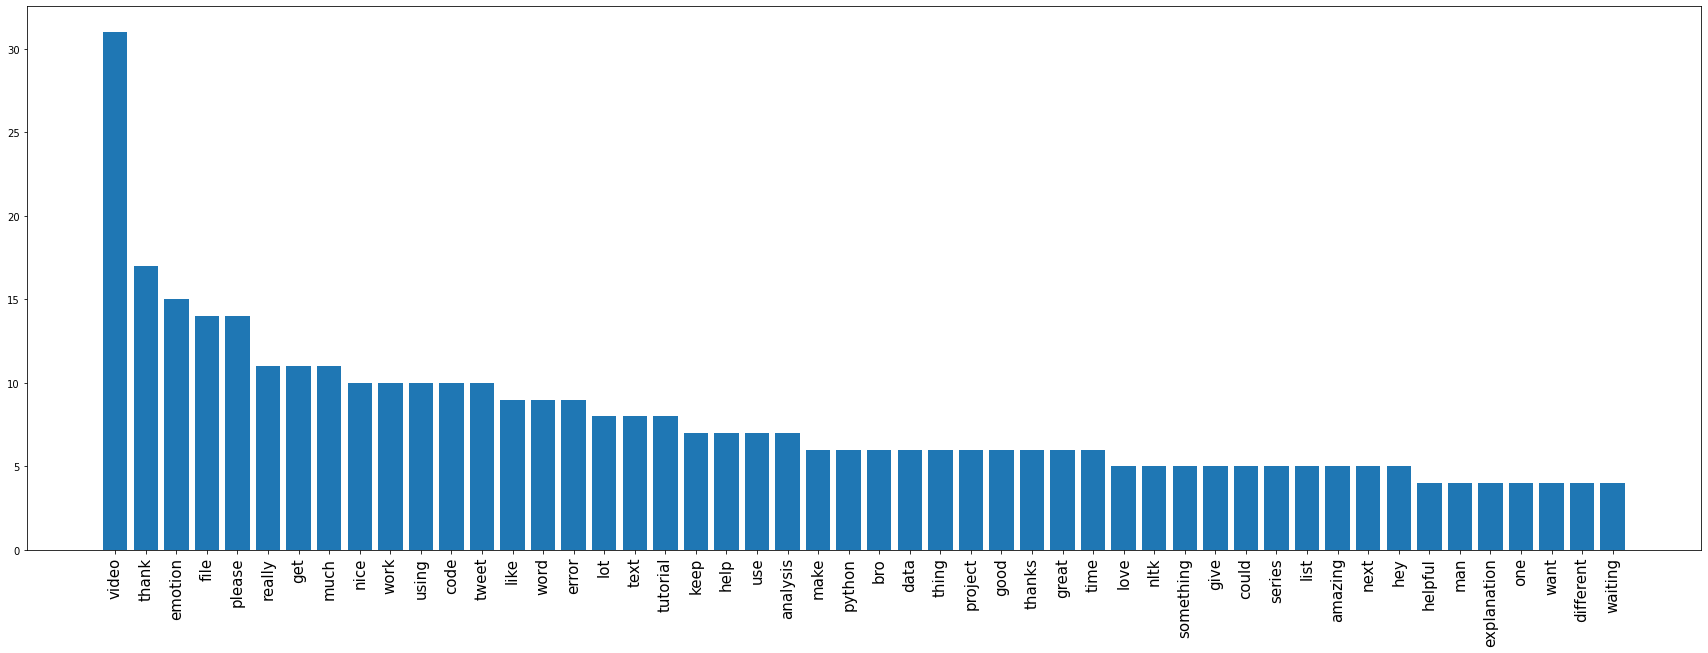

In [20]:
plt.figure(figsize=(30, 10))
plt.bar(word_df['word'].iloc[0:50], word_df['count'].iloc[0:50]) # only show first fifty entries, otherwise the bar chart would be unreadable
plt.xticks(rotation=90, size=15)
plt.show()

### Word Cloud: ###

The bar chart above seems a little bit messy. Therefore, let's plot a word cloud to visualize the word occurrences visually more appealing.

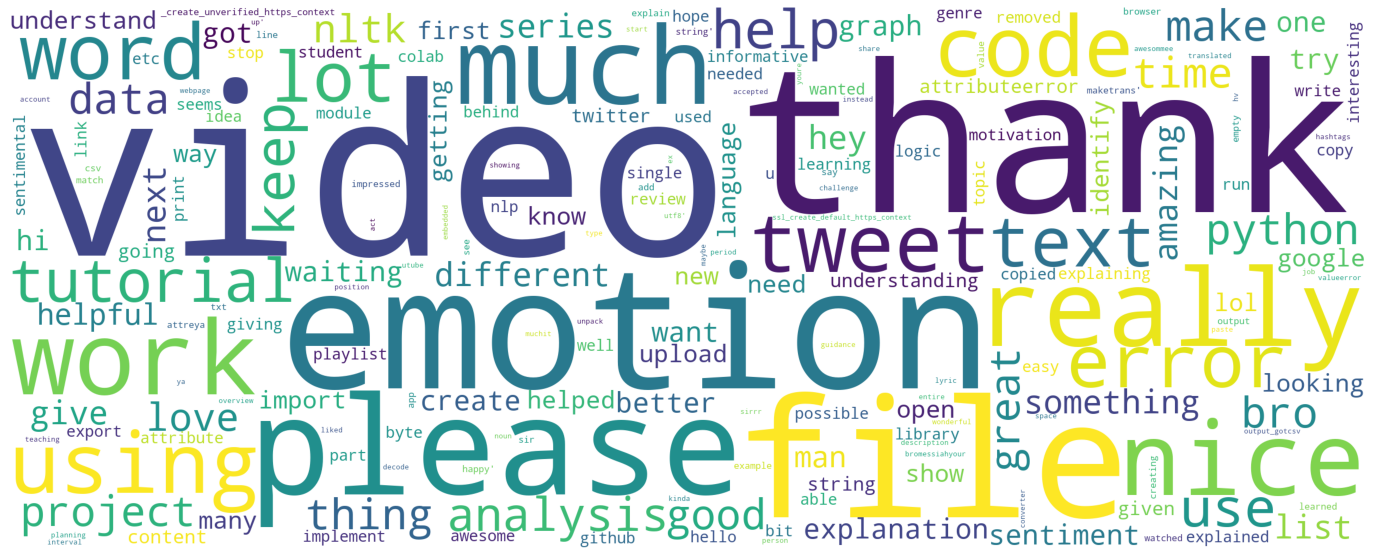

In [23]:
from wordcloud import WordCloud

word_string = ""

# create string of data frame for our wordcloud
# append words according to word_count to bias word cloud
for row in word_df.itertuples():
    for i in range(row[2]): # row[2] contains the word_count
        word_string += row[1] + " " # row[1] contains the actual word
        
wordcloud = WordCloud(
    background_color='white',collocations=False, width=2500, height=1000
).generate(word_string)

plt.figure(figsize = (25, 10)) # figsize must have the same ratio as width and height in WordCloud
plt.imshow(wordcloud)

plt.axis("off")
plt.show()

## Neo4j Query displayed in Bloom Browser: ##

For our last visualization of our query we have prepared the graphical output of a Neo4j query which includes every entity and relation. The picture below shows all videos in the playlist referencing their hashtags and corresponding comments written by their authors.

A brown circle represents a video, the red ones contain their corresponding hashtags and last but not least the green ones are authors of YouTube comments.
The arrows between the colored bubbles illustrate their relation.

We can see, that some authors commented on different videos. Other ones also commented more than once per video.

![title](images/neo4j_overview.png)